In [379]:
# for reloading the editable module
%load_ext autoreload
%autoreload 2

# Register your package and submodules
# %aimport probabilistic_load_forecast
# %aimport probabilistic_load_forecast.application.services
# %aimport probabilistic_load_forecast.adapters.db
# %aimport probabilistic_load_forecast.adapters.cds
# %aimport probabilistic_load_forecast.adapters.entsoe
# %aimport probabilistic_load_forecast.domain.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [380]:
from pathlib import Path
from dotenv import load_dotenv
from datetime import timezone, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

sns.set_theme(style="whitegrid")

In [381]:
# Import services and domain models
from probabilistic_load_forecast.application.services import (
    GetActualLoadData,
    GetERA5DataFromDB,
    GetERA5DataFromCDSStore,
    CreateCDSCountryAverages
) 

from probabilistic_load_forecast.domain.model import LoadMeasurement, LoadTimeseries, Era5Timeseries

# Import adapters for data access
from probabilistic_load_forecast.adapters.db import (
    EntsoePostgreRepository,
    Era5PostgreRepository
)

from probabilistic_load_forecast.adapters.entsoe import (
    EntsoeAPIClient,
    EntsoeFetcher,
    XmlLoadMapper,
    EntsoeDataProvider
)

from probabilistic_load_forecast.adapters.cds import (
    CDSAPIClient,
    CDSConfig,
    CDSDataProvider
)

# Import configuration
from probabilistic_load_forecast import config

# Load environment variables

if not load_dotenv(Path("../..") / ".env"):
    raise FileNotFoundError("Could not open the .env file.")

In [382]:
# Initialize database repositories
try:
    # Load data repository
    load_repo = EntsoePostgreRepository(config.get_postgre_uri())
    
    # ERA5 weather data repository
    era5_repo = Era5PostgreRepository(config.get_postgre_uri())
    
    print("Database repositories initialized successfully")
except Exception as e:
    print(f"Error initializing repositories: {e}")
    print("Make sure your .env file contains the correct database credentials")

Database repositories initialized successfully


In [454]:
# Initialize services
get_load_data = GetActualLoadData(load_repo)
get_era5_data = GetERA5DataFromDB(era5_repo)

print("Services initialized successfully")

Services initialized successfully


In [460]:
start = datetime(2018, 10, 1, 0, 0, tzinfo=timezone.utc)
end = datetime(2025, 10, 10, 0, 0, tzinfo=timezone.utc)

era5_variables=["t2m", "u10", "v10", "ssrd", "tp"]
era5_data = get_era5_data(variables=era5_variables, country_code="AT", start=start, end=end)
actual_load_ts = get_load_data(start, end)

# Amalysis of the Actual Load Data

In [386]:
actual_load_ts.data.describe()

,actual_load_mw
count,246337.000000
mean,6932.006812
std,1341.793121
min,4009.000000
25%,5858.000000
50%,6874.000000
75%,7884.000000
max,10818.000000


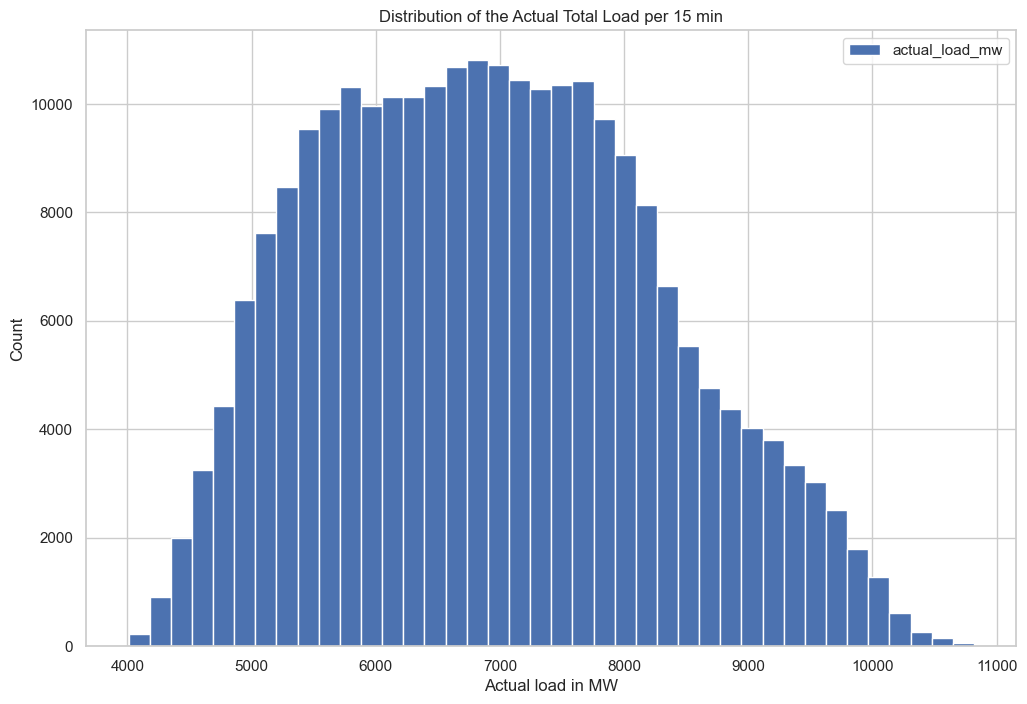

In [387]:
ax = sns.histplot(
    data=actual_load_ts.data,
    alpha=1.0,
    bins=40
)
ax.set_title("Distribution of the Actual Total Load per 15 min")
ax.set_xlabel("Actual load in MW");

The overall shape of the distribution seems approximately symmetric arount the mean of ~7000 MW per 15 min. The most values cluster between 6000 and 8000 MW.

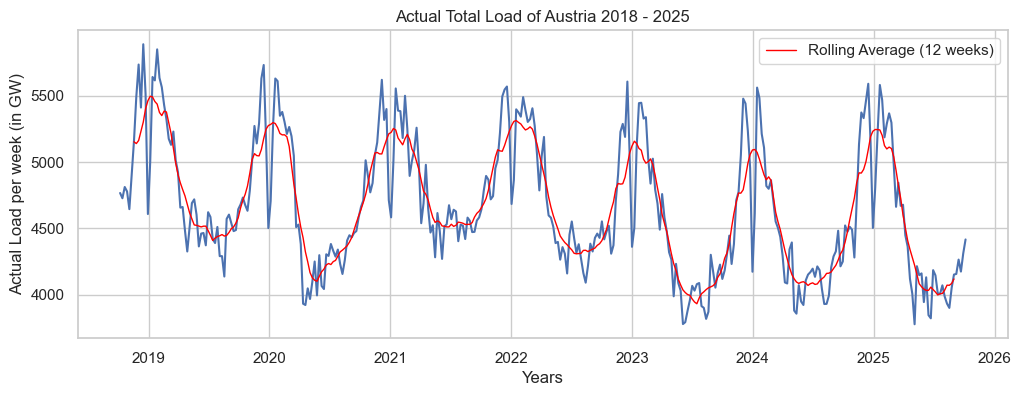

In [388]:
temp_df = actual_load_ts.data.reset_index()
temp_df["period"] = temp_df["period"].dt.to_timestamp()
temp_df_weekly = temp_df.resample("W", on="period").sum().reset_index()
temp_df_weekly.drop(index=temp_df_weekly.index[-1], inplace=True)

temp_df_gw = temp_df_weekly.copy()
temp_df_gw["actual_load_gw"] = temp_df_weekly["actual_load_mw"] / 1000
plt.figure(figsize=(12, 4))

ax = sns.lineplot(
    data=temp_df_gw,
    x="period",
    y="actual_load_gw",
);

ax.set_ylabel("Actual Load per week (in GW)");
ax.set_xlabel("Years");
ax.set_title("Actual Total Load of Austria 2018 - 2025")

load_rolling_avg = temp_df_gw["actual_load_gw"].rolling(window=12, center=True).mean()
ax.plot(temp_df_gw["period"], load_rolling_avg, color="red", lw=1, label="Rolling Average (12 weeks)")

ax.legend();

In this graph the influence of the corona pandemic from 2020, is quite distinctive: A clear drop in the actual load that might be coupled to the reduction of industrial production facilites or other business sectors facing less productivity in the lockdowns.

Summers after 2022 seem to have lower net loads in the summer which might be coupled to the increase of more renewable energies within the grid reducing.

Overall a strong seasonal effect is apparent in the data reflecting different load patterns in summer, winter, etc.

# Seasonality of the acutal total load

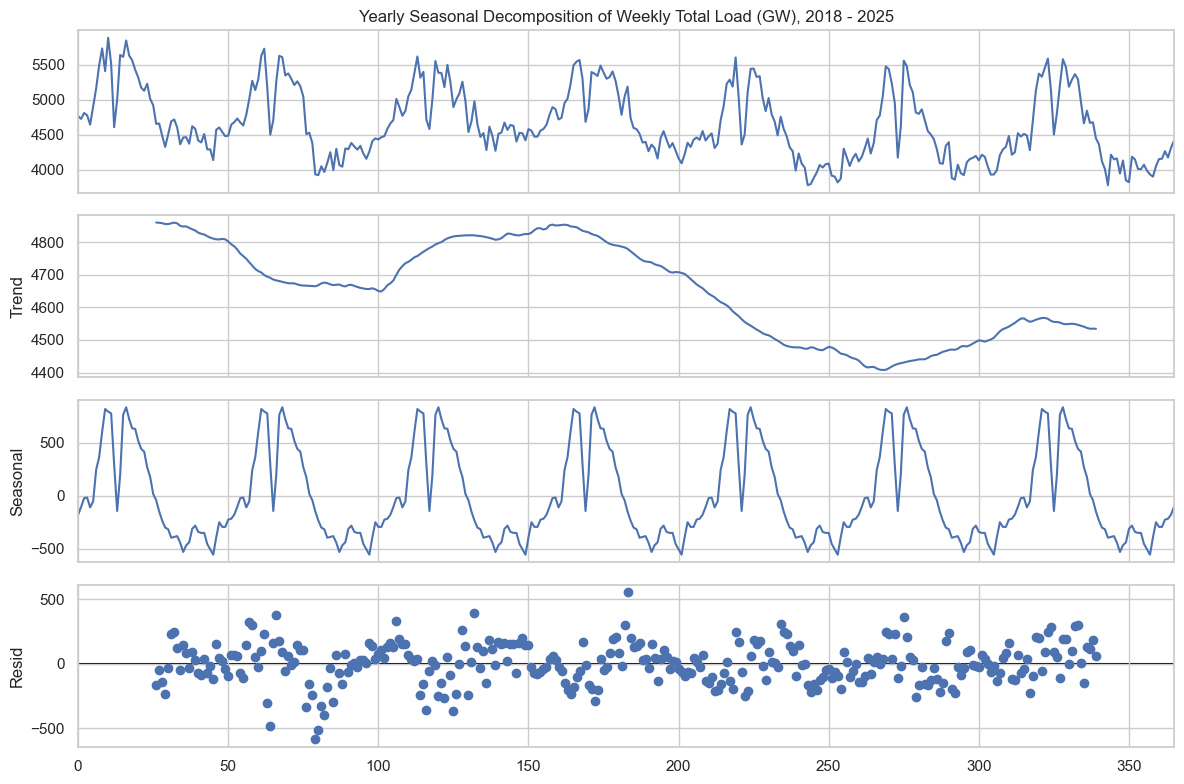

In [389]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(temp_df_gw["actual_load_gw"], model="additive", period=52)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title("Yearly Seasonal Decomposition of Weekly Total Load (GW), 2018 - 2025");

There is several information in plot. The yearly seasonality of the actual load data is quite pronounced as there is a yearly reoccuring rise of actual load in the winter season marked by distinctive drop in the end of the years around the holidays in december, which is further inspected in the graph below.

The seasonality of the plot seems to be relatively stable in the range of +550 to -500 GW.

The overall trend seems to include a drop during the corona pandemic followd by a short rise in load in the two consecutive years ending in a decline of total load to around ~4500 GW toward the end of the observation period. 

The randomly scattered residual component with no visible persistent structure suggests that the model did effectively capture the systematic patterns in the actual load timeseries.

In [390]:
df_actual_load_daily = temp_df.resample("D", on="period").sum().copy()
df_actual_load_daily["actual_load_gw"] = df_actual_load_daily["actual_load_mw"] / 1000
df_window = df_actual_load_daily[(df_actual_load_daily.index.month==12) | (df_actual_load_daily.index.month == 1)].copy()
df_window["seasonal_day"] = (
    ((df_window.index.month == 12) * (df_window.index.dayofyear - 334)) +  # Dec 1 -> 1
    ((df_window.index.month == 1) * (df_window.index.dayofyear + 31))      # Jan 1 -> 32
)

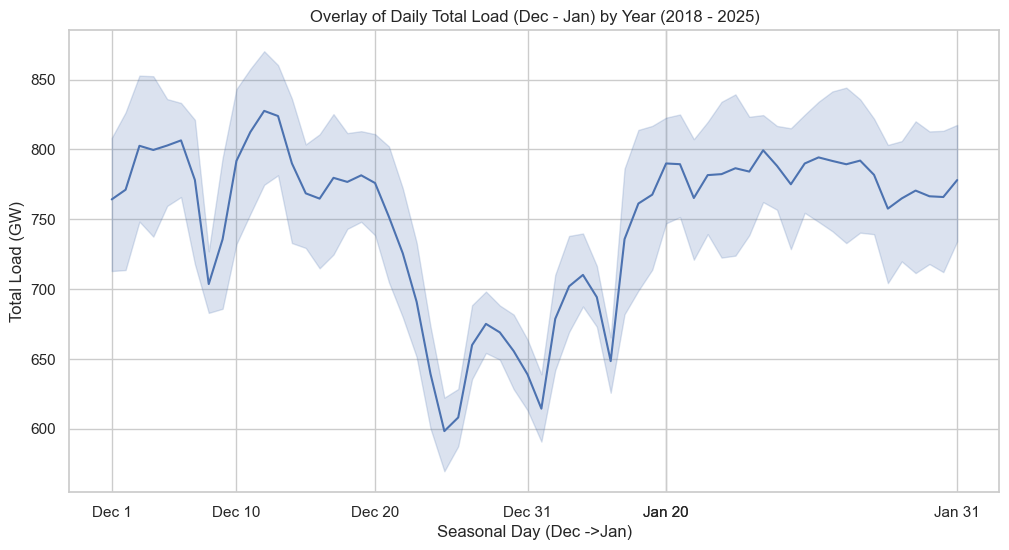

In [391]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_window,
    x="seasonal_day",
    y="actual_load_gw"
)
plt.title("Overlay of Daily Total Load (Dec - Jan) by Year (2018 - 2025)")
plt.xlabel("Seasonal Day (Dec -> Jan)")
plt.ylabel("Total Load (GW)")

ax.set_xticks([1, 10, 20, 31, 41, 41, 62])
ax.set_xticklabels(["Dec 1", "Dec 10", "Dec 20", "Dec 31", "Jan 10", "Jan 20", "Jan 31"])
ax.set_xlabel("Seasonal Day (Dec ->Jan)");

We can observe the daily total load follows a consistent yearly pattern, showing a distinct decline during the holidays period like Christmasday (25.12), Stefanitag (26.12) and New Year’s Day (01.01). This hints that holidays can be viable features when trying to forecast the actual total load.

# Weekly seasonal pattern

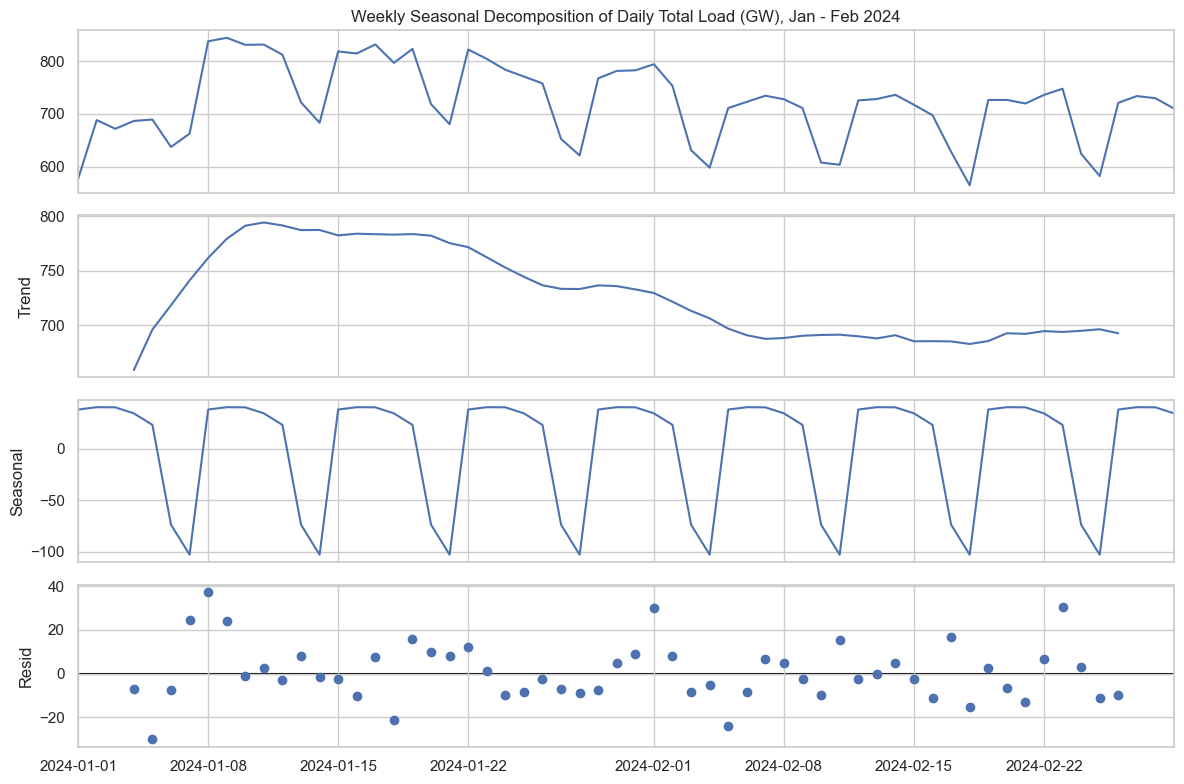

In [392]:
result = seasonal_decompose(df_actual_load_daily["2024-1":"2024-2"]["actual_load_gw"], model="additive", period=7)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title("Weekly Seasonal Decomposition of Daily Total Load (GW), Jan - Feb 2024");

The dayli load data exhibits a distinct weekly seasonal pattern characterized by a steep decline during weekends. Load levels drop on staturday reaching it's lowest point on sunday. This behavior might be related to decreased industrial and commercial activity over the weekend as many manifacturing and service sectors either operate at a reduced capacity on saturday or close entirely on sunday.

# Daily Pattern

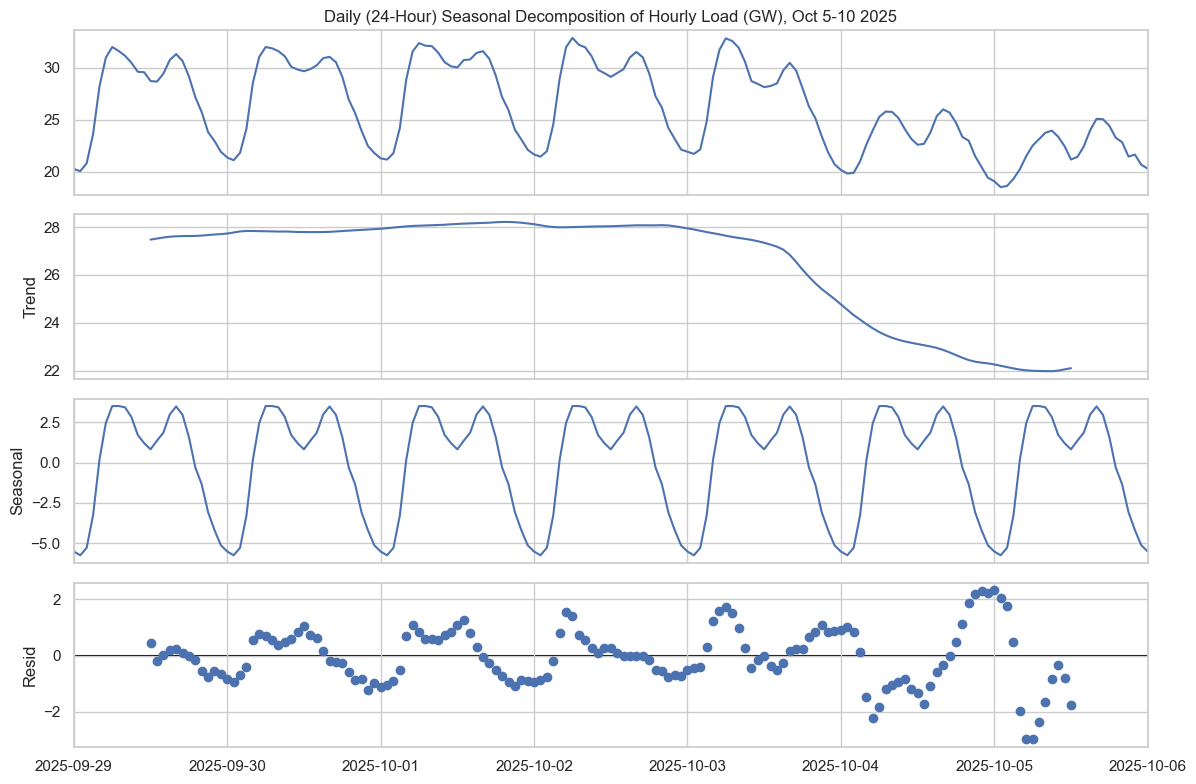

In [393]:
df_hourly = temp_df.resample("h", on="period").sum().copy()

result = seasonal_decompose(x=df_hourly["2025-09-29 00:00:00":"2025-10-06 00:00:00"]["actual_load_mw"]/1000, model="additive", period=24)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title("Daily (24-Hour) Seasonal Decomposition of Hourly Load (GW), Oct 5-10 2025");

The daily seasonal components in the graph above clearly indicate a seasonal pattern during the day which includes a sharp rise of load in the morning hours followed by a local minima at 12:00 after which the load rises again around the evining before declining overnight.

Furthermore there an overall weekly trend is observable which lines up perfectly with the previous made discovery of the weekly seasonal pattern which states that the load drops during the weekend.

# Hourly 

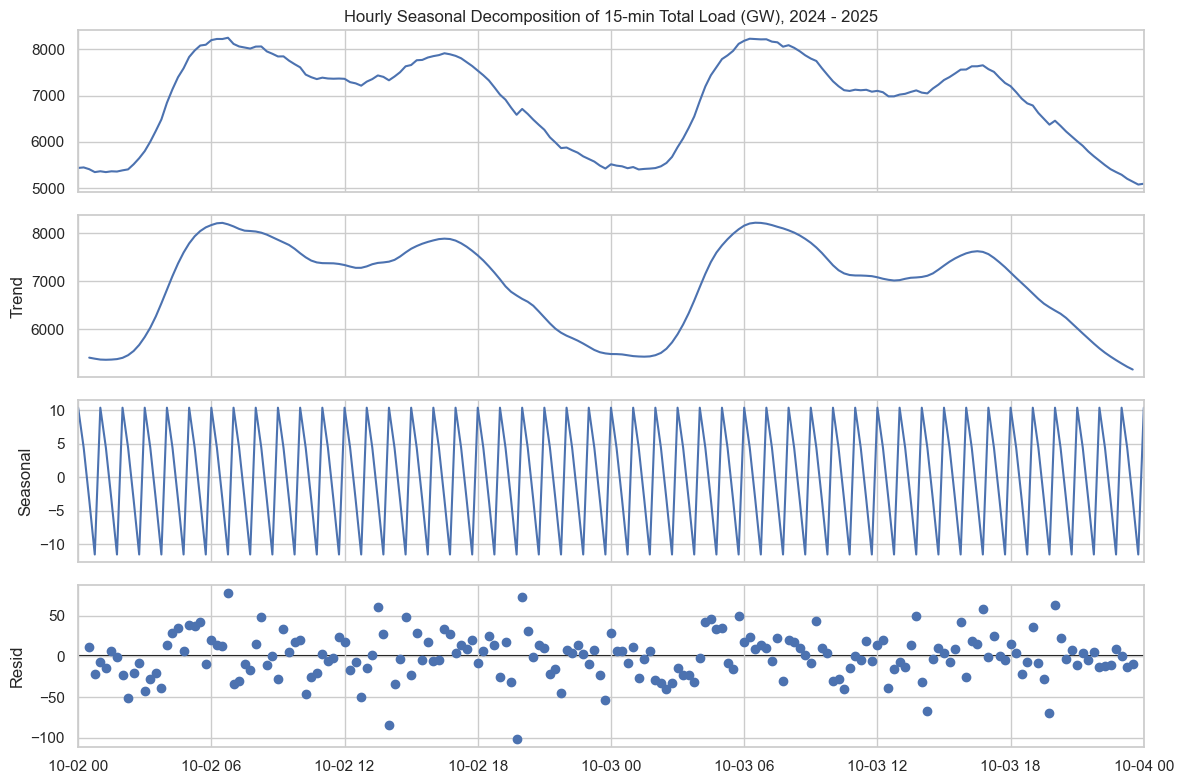

In [394]:
df_sample_actual_load = temp_df.set_index(keys="period")
result = seasonal_decompose(x=df_sample_actual_load["2025-10-2 00:00:00":"2025-10-4 00:00:00"]["actual_load_mw"], model="additive", period=4)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title("Hourly Seasonal Decomposition of 15-min Total Load (GW), 2024 - 2025");

Here the interday load pattern resembles the information seen in the last plot, the daily load increases in the morning hours around 06:00 decline to a local minima at 12:00 and peak again at 17:00 before finally declining overnight. The seasonal inter-hourly pattern might stem from grid optimization and varies for different dates, so it is not further investigated here.

# Auto Regression

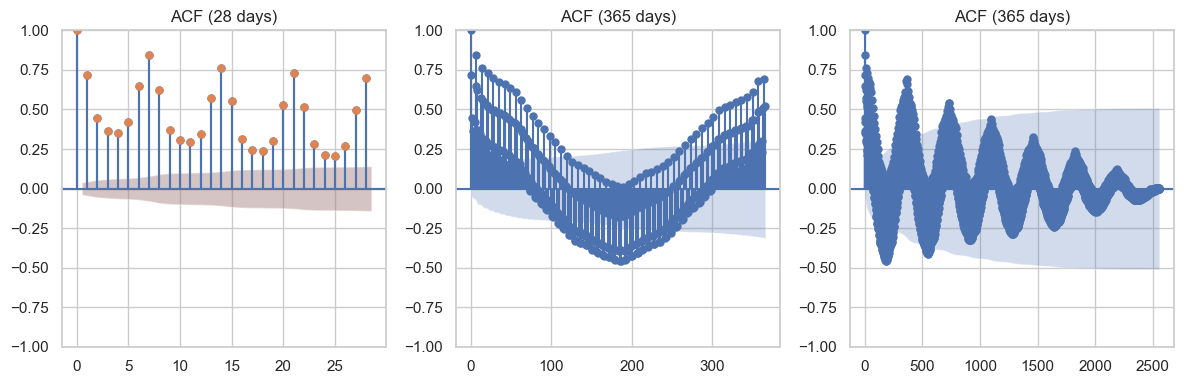

In [395]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_acf(df_actual_load_daily["actual_load_mw"], lags=28, ax=axes[0])
axes[0].set_title("ACF (28 days)")

plot_acf(df_actual_load_daily["actual_load_mw"], lags=28, ax=axes[0])
axes[0].set_title("ACF (28 days)")


plot_acf(df_actual_load_daily["actual_load_mw"], lags=365, ax=axes[1])
axes[1].set_title("ACF (365 days)")


plot_acf(df_actual_load_daily["actual_load_mw"], lags=365*7, ax=axes[2])
axes[2].set_title("ACF (365 days)")

plt.tight_layout()
plt.show()

Weekly:
The data indicates that there is a autocorrelation to the lagged values of the load at a lag-level around 7 which confirmes the previosly identified weekly seasonal pattern.

Yearly:
The data seems to be correlated with it lagged values reaching a low during a lag of ~ 180 and than rising again until becoming positive again at a lag of 365 which resembles a clear indicator for a strong yearly seasonality.

# Is the time series stationary?

 **ADF Test**

 * $H_0$: The series has a unit root (non-stationary).
 * $H_1$: The series is stationary.

In [396]:
from statsmodels.tsa.stattools import adfuller

adfuller(actual_load_ts.data["actual_load_mw"])

(np.float64(-9.937765732360843),
 np.float64(2.714862582066769e-17),
 85,
 246251,
 {'1%': np.float64(-3.4303765557019767),
  '5%': np.float64(-2.8615517372810446),
  '10%': np.float64(-2.5667762473305977)},
 np.float64(2693015.7816547058))

**ADF Statistic:** -9.94
* **p-value:** 2.7×10⁻¹⁷
* **Critical Values:**

   * 1%: -3.43
   * 5%: -2.86
   * 10%: -2.57

**Decision:** Reject $H_0$

**Interpretation:** The series is stationary in trend, although seasonality is present.

# Analysis of the Temperature at 2 meters

Description: 
	
Temperature of air at 2m above the surface of land, sea or in-land waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview


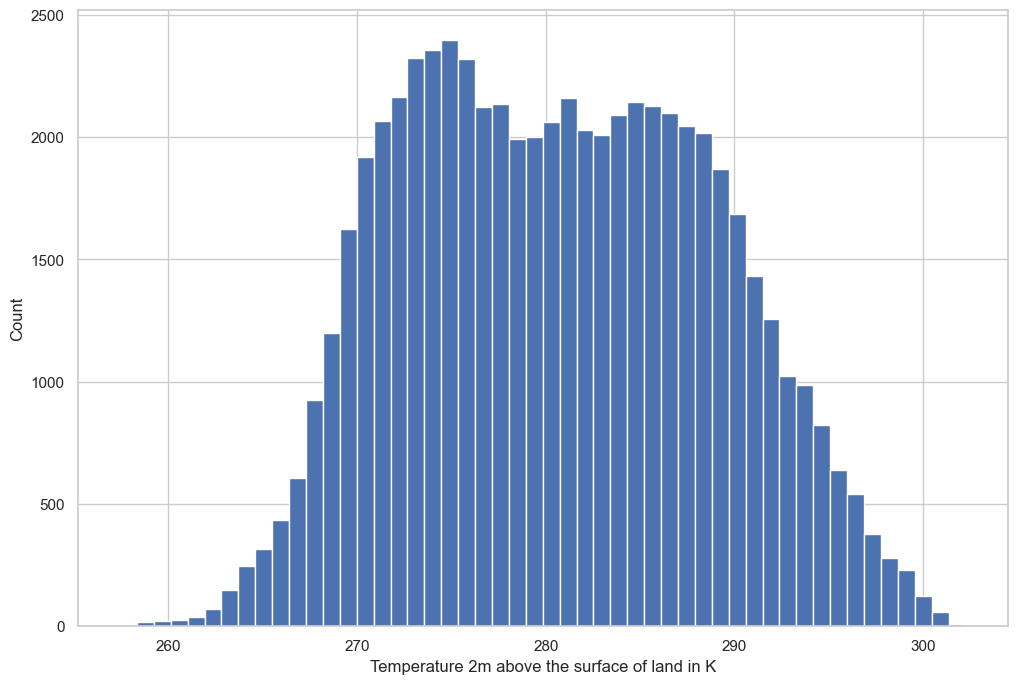

In [397]:
ax = sns.histplot(
    data=era5_data["t2m"],
    legend=False,
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Temperature 2m above the surface of land in K");

# Analysis of the Solar Radiation Downwards

Description: 

	
Amount of solar radiation (also known as shortwave radiation) reaching the surface of the Earth. This variable comprises both direct and diffuse solar radiation. Radiation from the Sun (solar, or shortwave, radiation) is partly reflected back to space by clouds and particles in the atmosphere (aerosols) and some of it is absorbed. The rest is incident on the Earth's surface (represented by this variable). To a reasonably good approximation, this variable is the model equivalent of what would be measured by a pyranometer (an instrument used for measuring solar radiation) at the surface. However, care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units are joules per square metre (J m^-2). To convert to watts per square metre (W m^-2), the accumulated values should be divided by the accumulation period expressed in seconds. The ECMWF convention for vertical fluxes is positive downwards.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

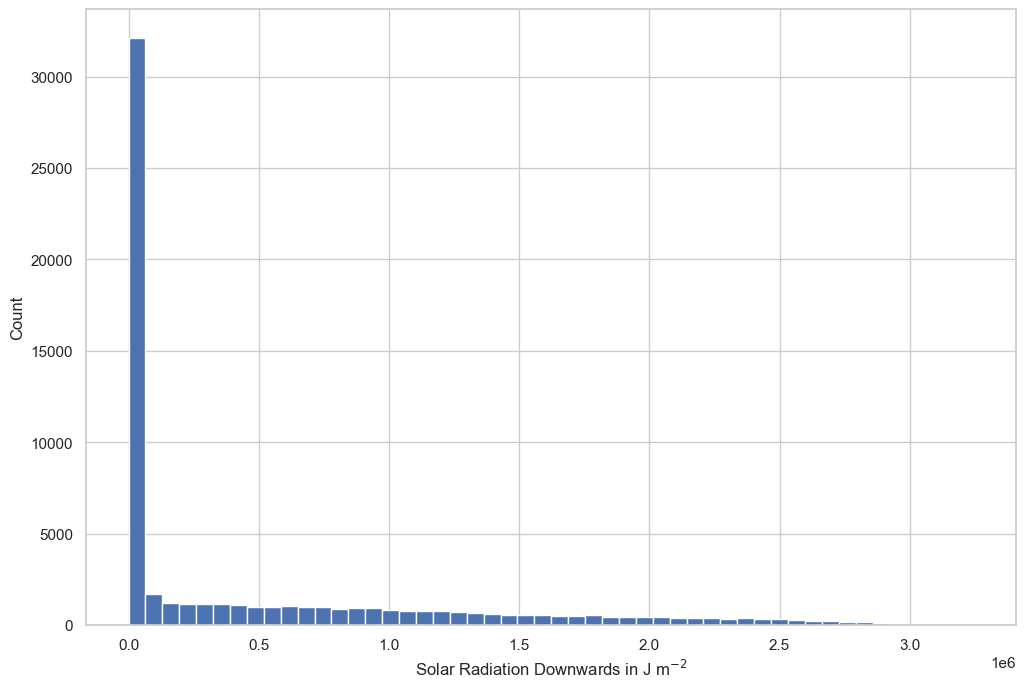

In [398]:
ax = sns.histplot(
    data=era5_data["ssrd"],
    legend=False,
    log_scale=(False, False),
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$");

The distribution seems failry right skewed, indicating that the most hours receive comparably small amounts of solar energy per square meter. 

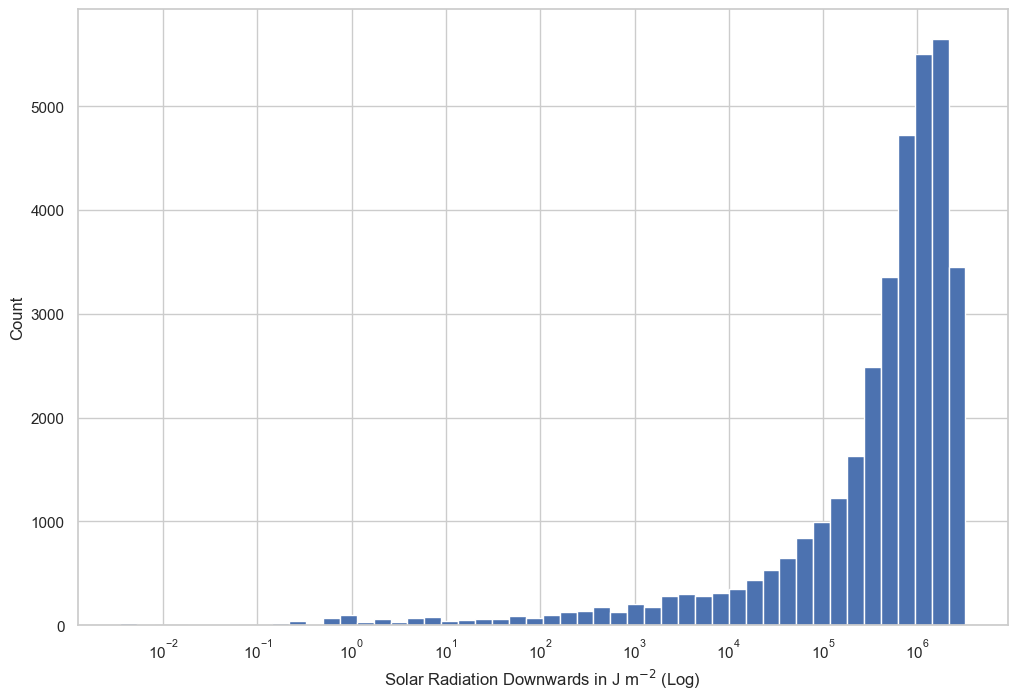

In [399]:
ax = sns.histplot(
    data=era5_data["ssrd"],
    legend=False,
    log_scale=(True, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$ (Log)");

After excluding the 0 values one can see that the must values are in the range of $10^{5}$ to $10^{6}$. 

# Analysis of the Total Precipitation

Description:

Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). Precipitation variables do not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

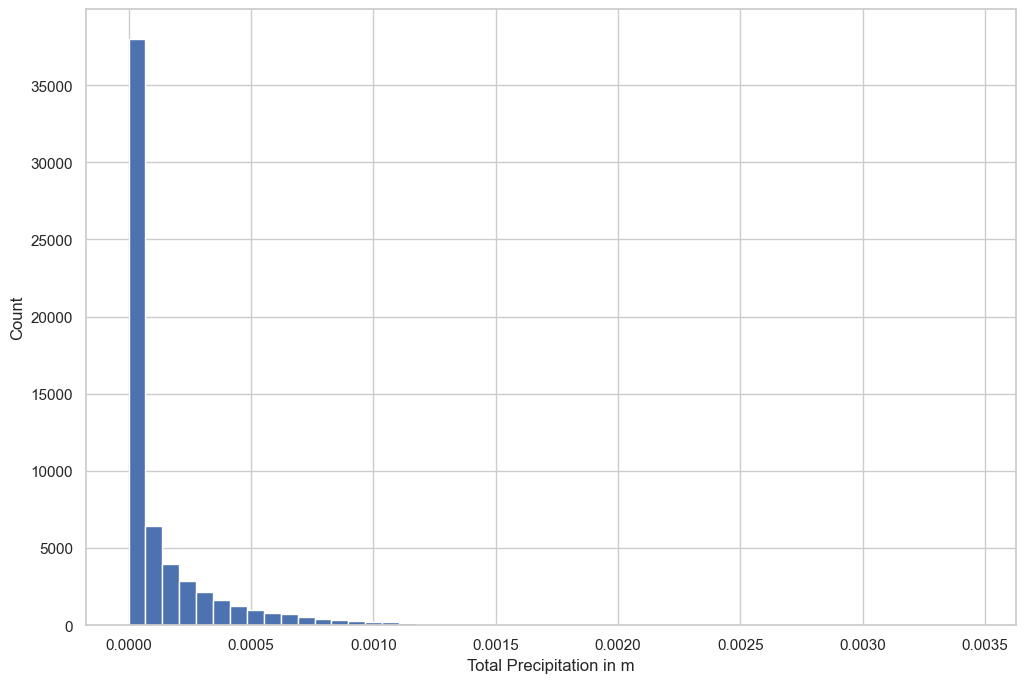

In [400]:
ax = sns.histplot(
    data=era5_data["tp"],
    legend=False,
    log_scale=(False, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Total Precipitation in m");

The must number of hours there seems to be no to little total precipitation.

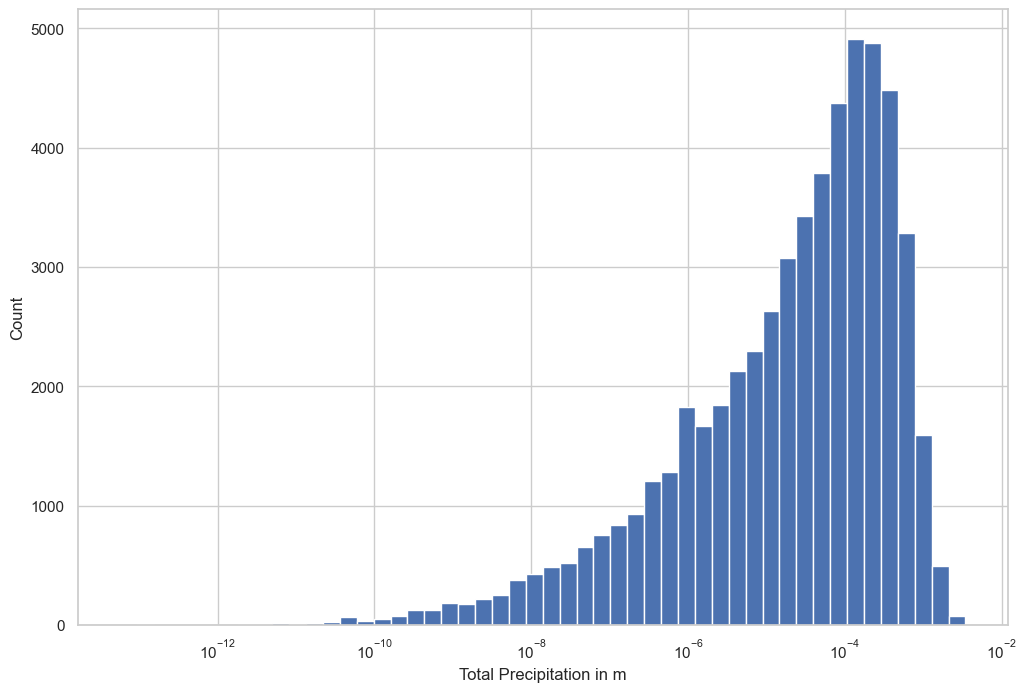

In [401]:
ax = sns.histplot(
    data=era5_data["tp"],
    legend=False,
    log_scale=(True, False),
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Total Precipitation in m");

Plotting the data after excluding 0 values it becomes evident that most of the values are within a range of $10^{-6}$ to $10^{-2}$ eg. are range of 0.001 mm to 10 mm over the total area of austria.

# Analysis of the Zonal wind component

Description:

Eastward component of the 10m wind. It is the horizontal speed of air moving towards the east, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the V component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview

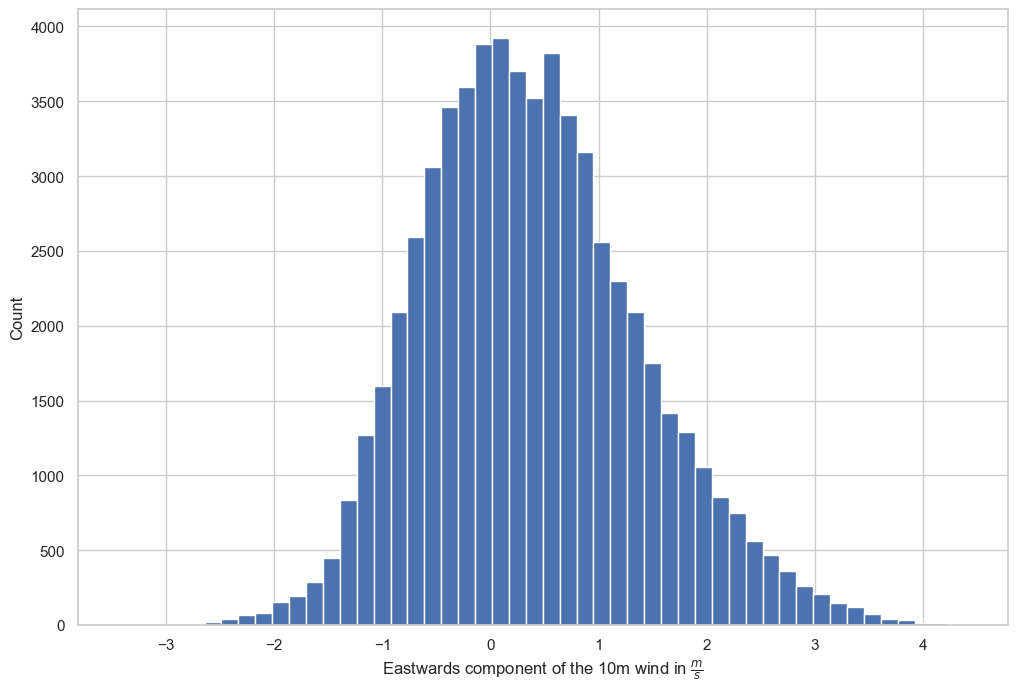

In [402]:
ax = sns.histplot(
    data=era5_data["u10"],
    legend=False,
    log_scale=False,
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Eastwards component of the 10m wind in $\\frac{m}{s}$");

The overall averaged sum of east-west wind seems to be fairly normal distrubuted in the range of 4 $\frac{m}{s}$ to 3 $\frac{m}{s}$.  

# Analysis of the Meridional wind component

Description:

Northward component of the 10m wind. It is the horizontal speed of air moving towards the north, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the U component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

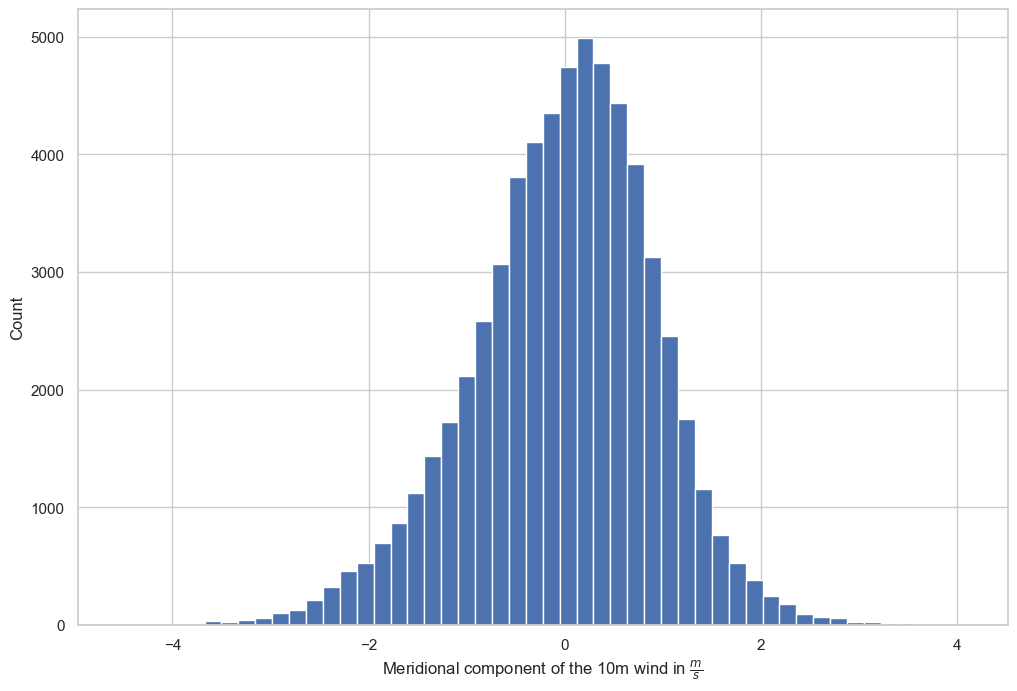

In [403]:
ax = sns.histplot(
    data=era5_data["v10"],
    legend=False,
    log_scale=False,
    alpha=1.0,
    bins=50
)

ax.set_xlabel("Meridional component of the 10m wind in $\\frac{m}{s}$");

The overall country averaged sum of south-north wind seems to be in the same range as the zonal wind component (4 $\frac{m}{s}$ to 3 $\frac{m}{s}$).  

# Multivaraite analysis

In [512]:
# Build a dataframe for the correlation calculation
corr_matrix = df_hourly.copy()

# Prepare Names the names for the columns
for var in era5_variables:
    era5_var = era5_data[var].rename(columns={"value": var})

    if isinstance(era5_var.index, pd.PeriodIndex):
        era5_var.index = era5_var.index.to_timestamp()
        era5_var.index = era5_var.index.tz_localize("UTC")

    corr_matrix = corr_matrix.join(era5_var)

# Get the average wind speed
corr_matrix["wind_speed"] =np.sqrt(corr_matrix["u10"]**2 + corr_matrix["v10"]**2)
corr_matrix.drop(columns=["u10", "v10"], inplace=True)

# Get the solar irridiation in W/m^2
# corr_matrix["ssrd"]= corr_matrix["ssrd"] / 3600

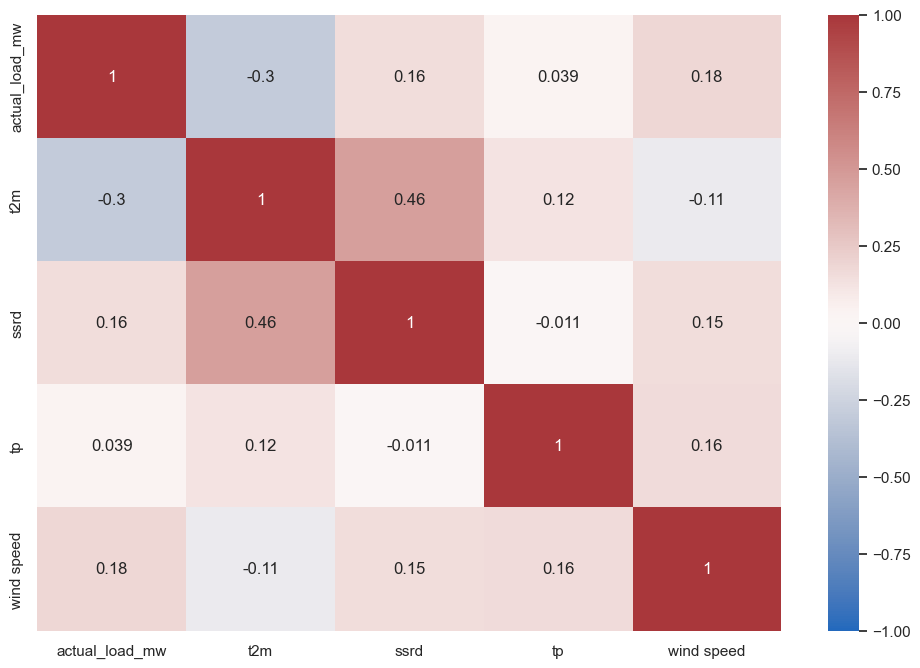

In [495]:
sns.heatmap(
    data=corr_matrix.corr(),
    vmin=-1,
    vmax=1,
    cmap="vlag",
    annot=True
);

The values in this plot show the correlations of the raw timeseries which might indicate a relationship of the variables or just those are just spurious.

In [646]:
from statsmodels.tsa.stattools import ccf

def get_ccf_plot(x, y, era_5_var: str, ax, max_lag=7*24):
    """Plot the cross-correlation plot for a era5 variable and the actual load target"""

    cross_corr, confint = ccf(x=y, y=x, nlags=max_lag, alpha=True)
    lags = np.arange(max_lag)


     # Plot on provided axis
    ax.bar(lags, cross_corr, width=0.8)
    ax.fill_between(lags, confint[:, 0], confint[:, 1], color="red", alpha=1, zorder=0)
    ax.axhline(0, color='black', lw=1)
    ax.set_title(f"CCF: Load vs {era_5_var}")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Correlation coefficient")


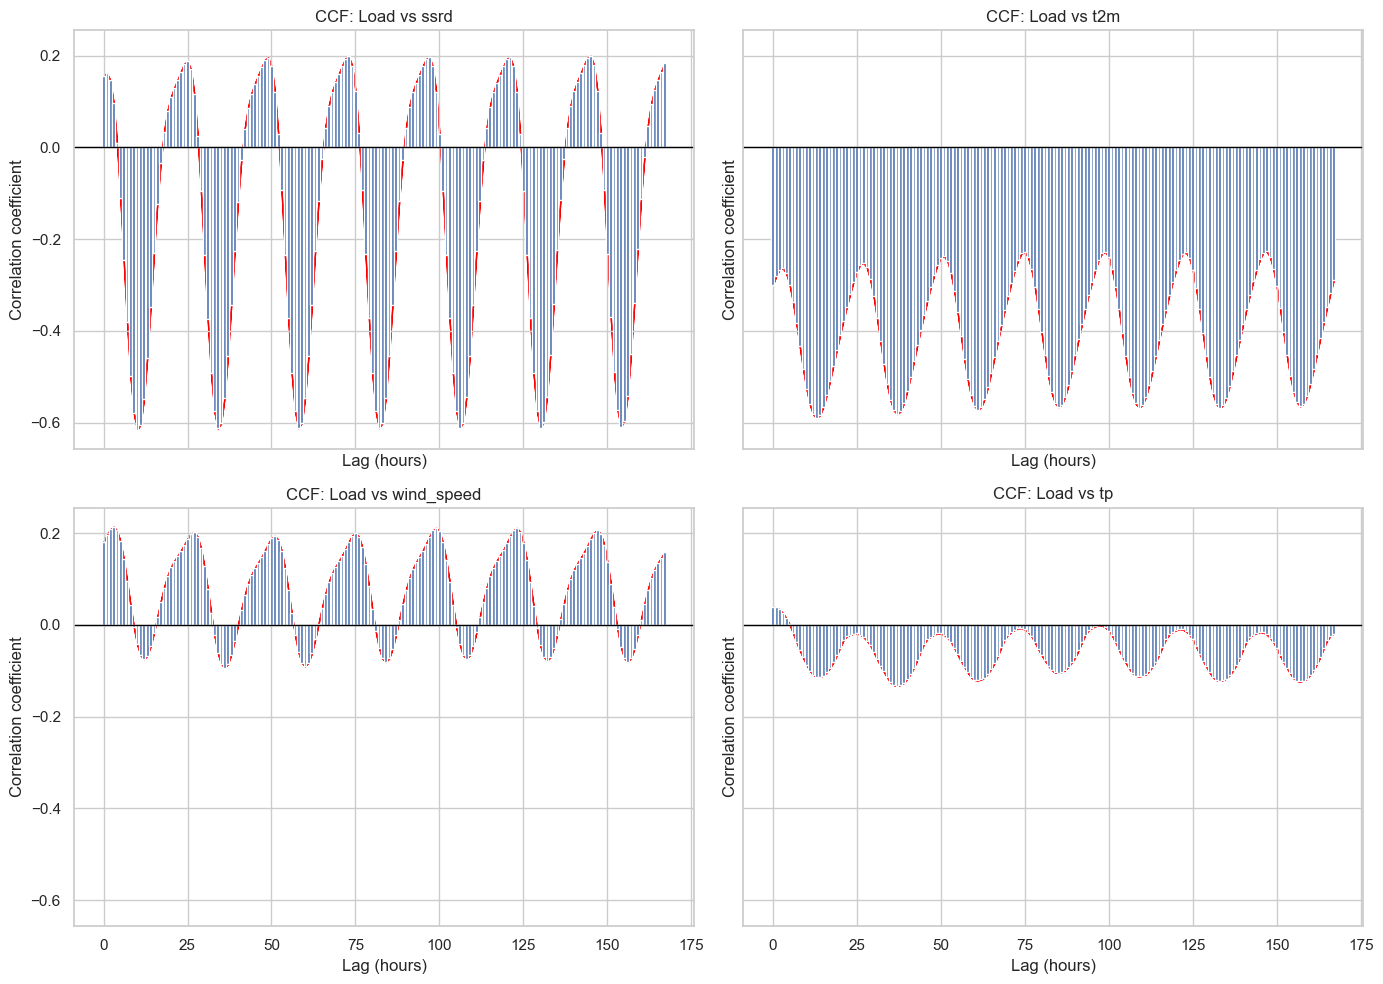

In [647]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

era5_vars = ["ssrd", "t2m", "wind_speed", "tp"]

x = corr_matrix["actual_load_mw"].dropna()

for ax, var in zip(axes.flatten(), era5_vars):
    y = corr_matrix[var].dropna()
    get_ccf_plot(x=x, y=y, era_5_var=var, ax=ax, max_lag=7*24)

plt.tight_layout()

Ignoring the fact that the relations might be spurious, I tried to plot the cross-correlation of the variable leading the target which shows a periodic correlation which indicates that we are not measuring the true relationship but the seasonal components might match up for the two timeseries. As none if the bars is outside of the errorband this implies that the weather shares a common seasonal cicle (daily) there is no statistically significant linear correlation.

In fact to uncover the real correclation of the timeseries, we need to detrend and deseasonalize them to get the valid correlation values and not measure the coincidence.

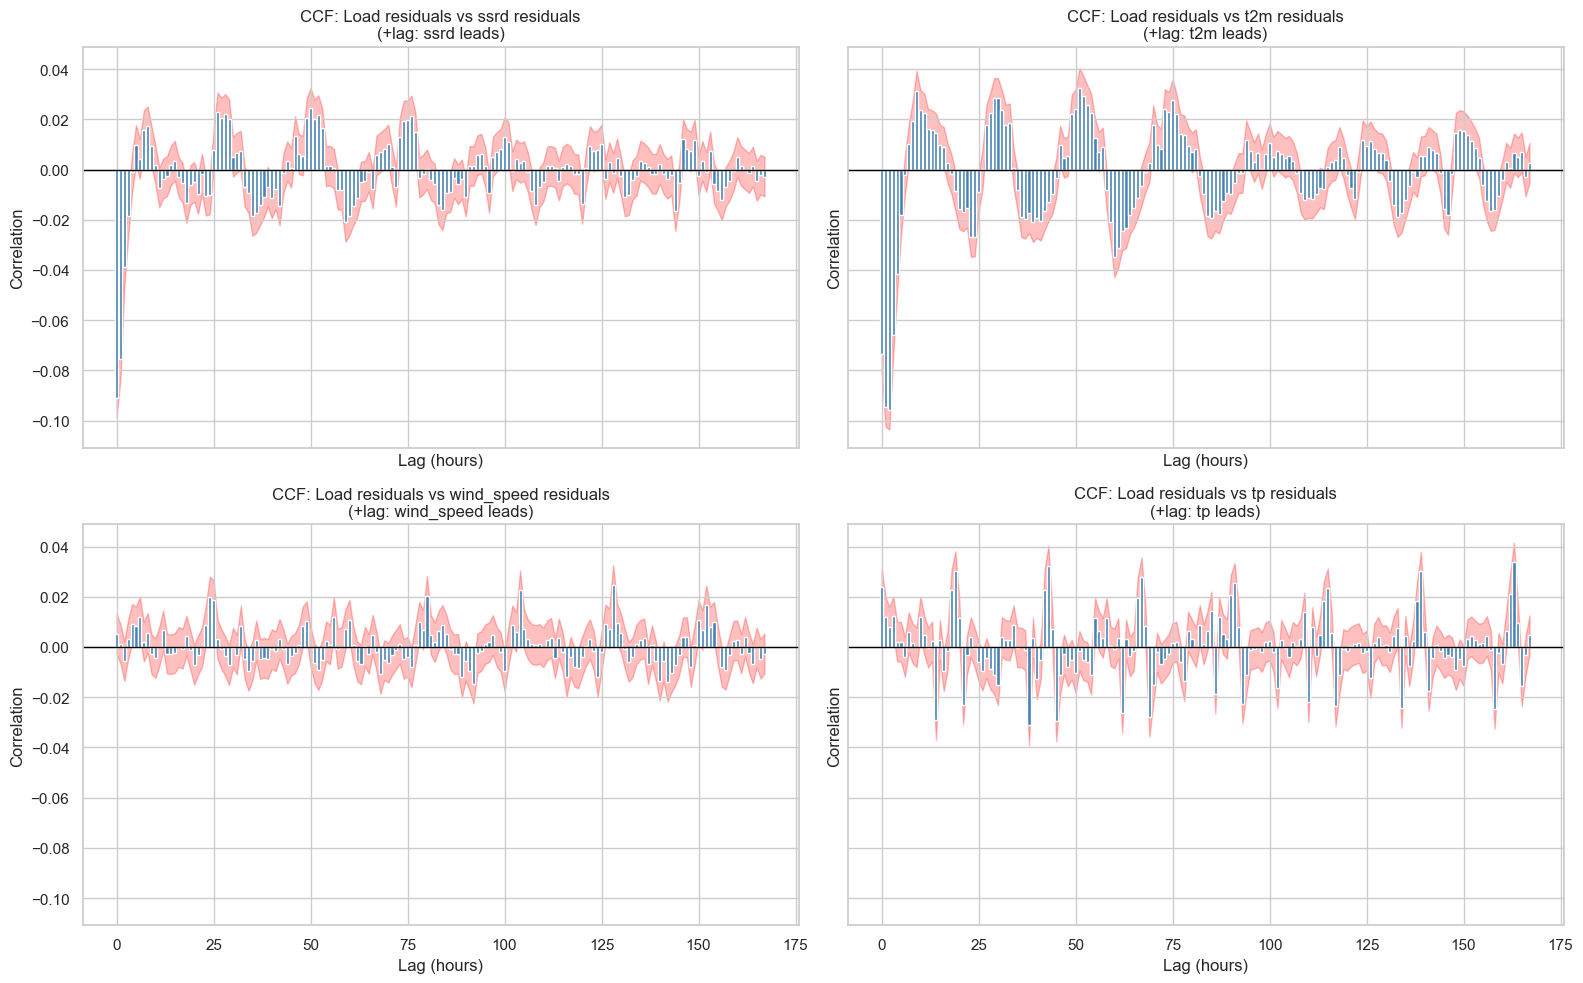

In [643]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf

def stl_residuals(s: pd.Series, period=24) -> pd.Series:
    """Deseasonalize & detrend via STL; return residuals (no edge NaNs)."""
    stl = STL(s, period=period, robust=True).fit()
    return stl.resid.dropna()

def prewhiten(resid: pd.Series, ar_order=1) -> pd.Series:
    """Remove remaining short-memory autocorr with a small AR model; return residuals."""
    model = ARIMA(resid, order=(ar_order, 0, 0)).fit(method_kwargs={"warn_convergence": False})
    return model.resid.dropna()

def prepared_residuals(s: pd.Series, period=24) -> pd.Series:
    """STL residuals + AR(1) prewhitening, ready for CCF."""
    return prewhiten(stl_residuals(s, period=period))

def plot_ccf_on_ax(ax, target_resid: pd.Series, pred_resid: pd.Series,
                   max_lag=7*24, alpha=0.05, title=""):
    """
    Plot CCF on a provided Axes.
    We call ccf(x=pred, y=target) so POSITIVE lags mean predictor leads target.
    """
    # Align so we correlate the same timestamps
    y, x = target_resid.align(pred_resid, join="inner")  # y=target (load), x=predictor
    if len(x) == 0:
        ax.set_title(f"{title}\n(no overlap)"); return ax

    if alpha is None:
        vals = ccf(x=x, y=y, nlags=max_lag)
        conf = None
    else:
        vals, conf = ccf(x=x, y=y, nlags=max_lag, alpha=alpha)

    lags = np.arange(max_lag)
    ax.bar(lags, vals, width=0.8, color="steelblue")
    ax.axhline(0, color="black", lw=1)

    if conf is not None:
        ax.fill_between(lags, conf[:, 0], conf[:, 1], color="red", alpha=0.25, zorder=0)

    ax.set_title(title or "CCF")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Correlation")
    return ax


# 1) Prepare residuals for the TARGET once
x_resid = prepared_residuals(corr_matrix["actual_load_mw"], period=24)

# 2) Variables to compare against the target
era5_vars = ["ssrd", "t2m", "wind_speed", "tp"]

# 3) Faceted CCFs
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, var in zip(axes.flatten(), era5_vars):
    y_resid = prepared_residuals(corr_matrix[var], period=24)
    plot_ccf_on_ax(
        ax=ax,
        target_resid=x_resid,
        pred_resid=y_resid,
        max_lag=7*24,
        alpha=0.05,
        title=f"CCF: Load residuals vs {var} residuals\n(+lag: {var} leads)"
    )

plt.tight_layout()
plt.show()


The main goal of computing the lagged correlations for the variables leading load after being detrended, deseasonalized and autoregression removed was to find if the residuals of both timeseries are linearly correlated. In other words, I wanted to see whether an unexpected deviation in a weather variable leads to a corresponding delayed response in the load, beyond what is already explained by seasonal and trend effects.

As the plot above shows this is not the case, the correlation values are all within the confidence intervales eg. none is being significant. This indicates that once the common seasonal and trend components are removed, the residuals of the weather variables and the load are not correlated and the short-term fluctuations of weather do not systematically drive the short-term fluctuations of load.

Consequently, the observed relationships between load and weather are largely explained by seasonal effects and no lagged versions of the weather variables are needed in the forecasting model. While the cross-correlation function did not show statistically significant coefficients at any lag, the strong visual and physical correspondence between load and weather variables indicates that these factors contribute to the systematic seasonal variation in load. The lack of significant residual correlation simply confirms that no additional short-term linear dependence remains once this structure is modeled.

# Check if there is Multicolinearity

In [658]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = corr_matrix[era5_vars]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,ssrd,1.537854
1,t2m,4.190195
2,wind_speed,4.019941
3,tp,1.331330


There seems to be no multicolinearity between the variables which mean all of them can be considered for modelling in the next steps.